In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter("ignore", UserWarning)

In [2]:
from scipy.signal import butter, filtfilt, group_delay, firwin, freqz

def mydft(sample_frq, time_domain):

    sample_interval = 1.0/sample_frq;
    samples = len(time_domain) # length of the signal
    k = np.arange(samples) 
    frq_range = k*(sample_frq/samples) # two sides frequency range
    frq_domain = np.fft.fft(time_domain)/samples # DFT computing and normalization

    return (frq_range, frq_domain)

def myidft(frq_domain):
    samples = len(frq_domain) # length of the signal
    time_domain = np.fft.ifft(samples*frq_domain) # Denormalization and IDFT computing
    return time_domain

def myfilter(sample_frq, time_domain, pass_interval, order=5, filter_type="fir", band_stop=False):
    if(band_stop):
        ftype = "bandstop"
    else:
        if(len(pass_interval) == 1):
            ftype = "highpass"
        elif(pass_interval[0] == 0):
            ftype = "lowpass"
        else:
            ftype = "bandpass"
    
    if(ftype == "bandpass" or ftype == "bandstop"):
        norm_frq = []
        for f in pass_interval:
            norm_frq.append(f/((sample_frq/2))) # normalizing with the nyquist frequency
    elif(ftype == "lowpass"):
        norm_frq = pass_interval[1] / (sample_frq/2)
    else:
        norm_frq = pass_interval[0] / (sample_frq/2)
        
    if(filter_type=="fir"):
        b = firwin(order-1, norm_frq, pass_zero=ftype)
        a = 1
    elif(fitter_type=="butterworth"):
        b, a = butter(N=order, Wn=norm_frq, btype=ftype, analog=False)
    else:
        raise Exception("Filter type {} not recocnized.".format(filter_type))
    filtered_time_domain = filtfilt(b, a, time_domain)
    
    
    # Delay correction
    _, delay = group_delay((b, a))
    delay = int(np.round(np.mean(delay)))
    filtered_time_domain = filtered_time_domain[delay:-1]
    
    return filtered_time_domain

In [3]:
from scipy.signal import hilbert

def getInstantaneousFrequency(sample_frq, time_domain):
    analytic_signal = hilbert(time_domain) # use the hilbert transform
    phase = np.angle(analytic_signal) # calculate the phase of the analytic signal
    phase = np.unwrap(phase) # unwrap the phase
    frequency = np.diff(phase) # differentiantion of the phase to get the frequency
    frequency = abs(frequency/((2.0*np.pi)*sample_frq)) # denormalization of the frequency
    return frequency


In [4]:
from copy import deepcopy

def normalize(data):
    ndata = deepcopy(data)
    for key in ndata:
        minv = min(ndata[key])
        maxv = max(ndata[key])
        vrange = maxv-minv
        ndata[key]-=minv
        ndata[key]/=vrange
    
    return ndata

In [5]:
sample_rate = 512 # frequencia de amostragem, 512 Hz
blinking_signal_frq = [4, 7] # intervalo de frequências dos sinais de piscada de olho
filter_order = 1000 # ordem do filtro a ser utilizada
best_channels = ["Channel 2", "Channel 6"]

In [6]:
raw_data = pd.read_csv("data/record-[2018.11.16-10.16.29].csv")

In [7]:
def treatData():
    # Remocao de colunas nao utilizadas
    global data, time_data, frequency_data
    data = raw_data.drop(["Event Id",
                          "Event Date",
                          "Event Duration",
                          "Epoch",
                          "Channel 1",
                          "Channel 4",
                          "Channel 5",
                          "Channel 9",
                          "Channel 12",
                          "Channel 13",
                          "Channel 16"], axis=1)
    # Separacao da coluna de tempo
    time_data = data["Time:512Hz"]
    data = data.drop(["Time:512Hz"], axis=1)
    frequency_data = pd.DataFrame()
    for key in data:
        frequency_data[key+" F"] = getInstantaneousFrequency(sample_rate, data[key])
    # Remover ultimo ponto dos dados pois o calculo da frequencia instantanea usa uma derivada, causando a perda de um ponto.
    data = data.drop(data.index[-1])
    time_data = time_data.drop(time_data.index[-1])
    frequency_data
treatData()

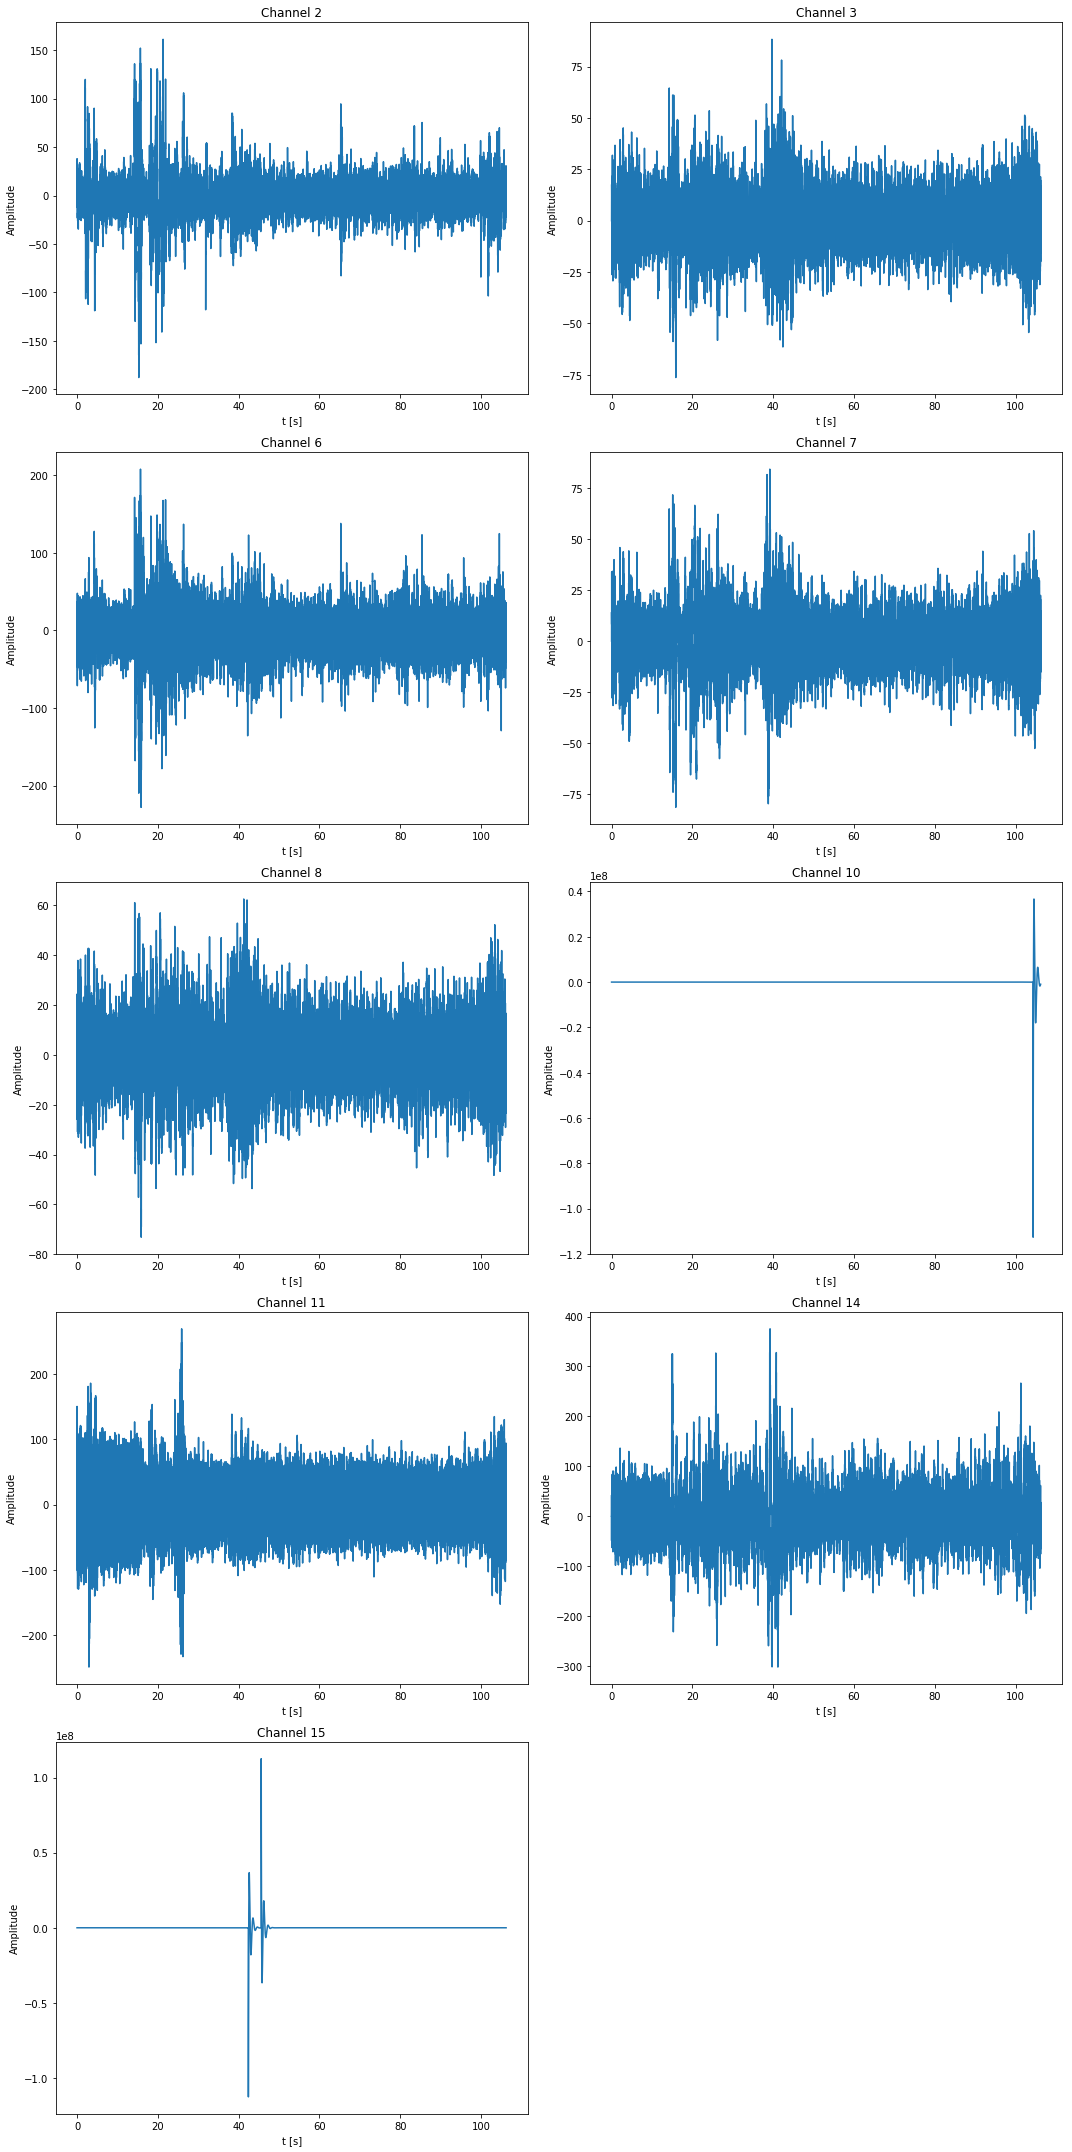

In [8]:
def plotTime(data, time_data):
    fig, ax = plt.subplots(5, 2, figsize=(15,30))
    line = 0
    column = 0
    for key in data:
        ax[line][column].plot(time_data, data[key])
        ax[line][column].set_title(key)
        ax[line][column].set_xlabel("t [s]")
        ax[line][column].set_ylabel("Amplitude")
        if(column == 1):
            line += 1
            column = 0
        else:
            column = 1

    fig.delaxes(ax[4][1])
    plt.tight_layout()

plotTime(data, time_data)

In [9]:
frq_data = pd.DataFrame()
frq_range = None # este valor sera o mesmo para todos os canais, como a taxa de amostragem e a mesma
for key in data:
    frq_range, frq_data[key] = mydft(sample_rate, data[key])

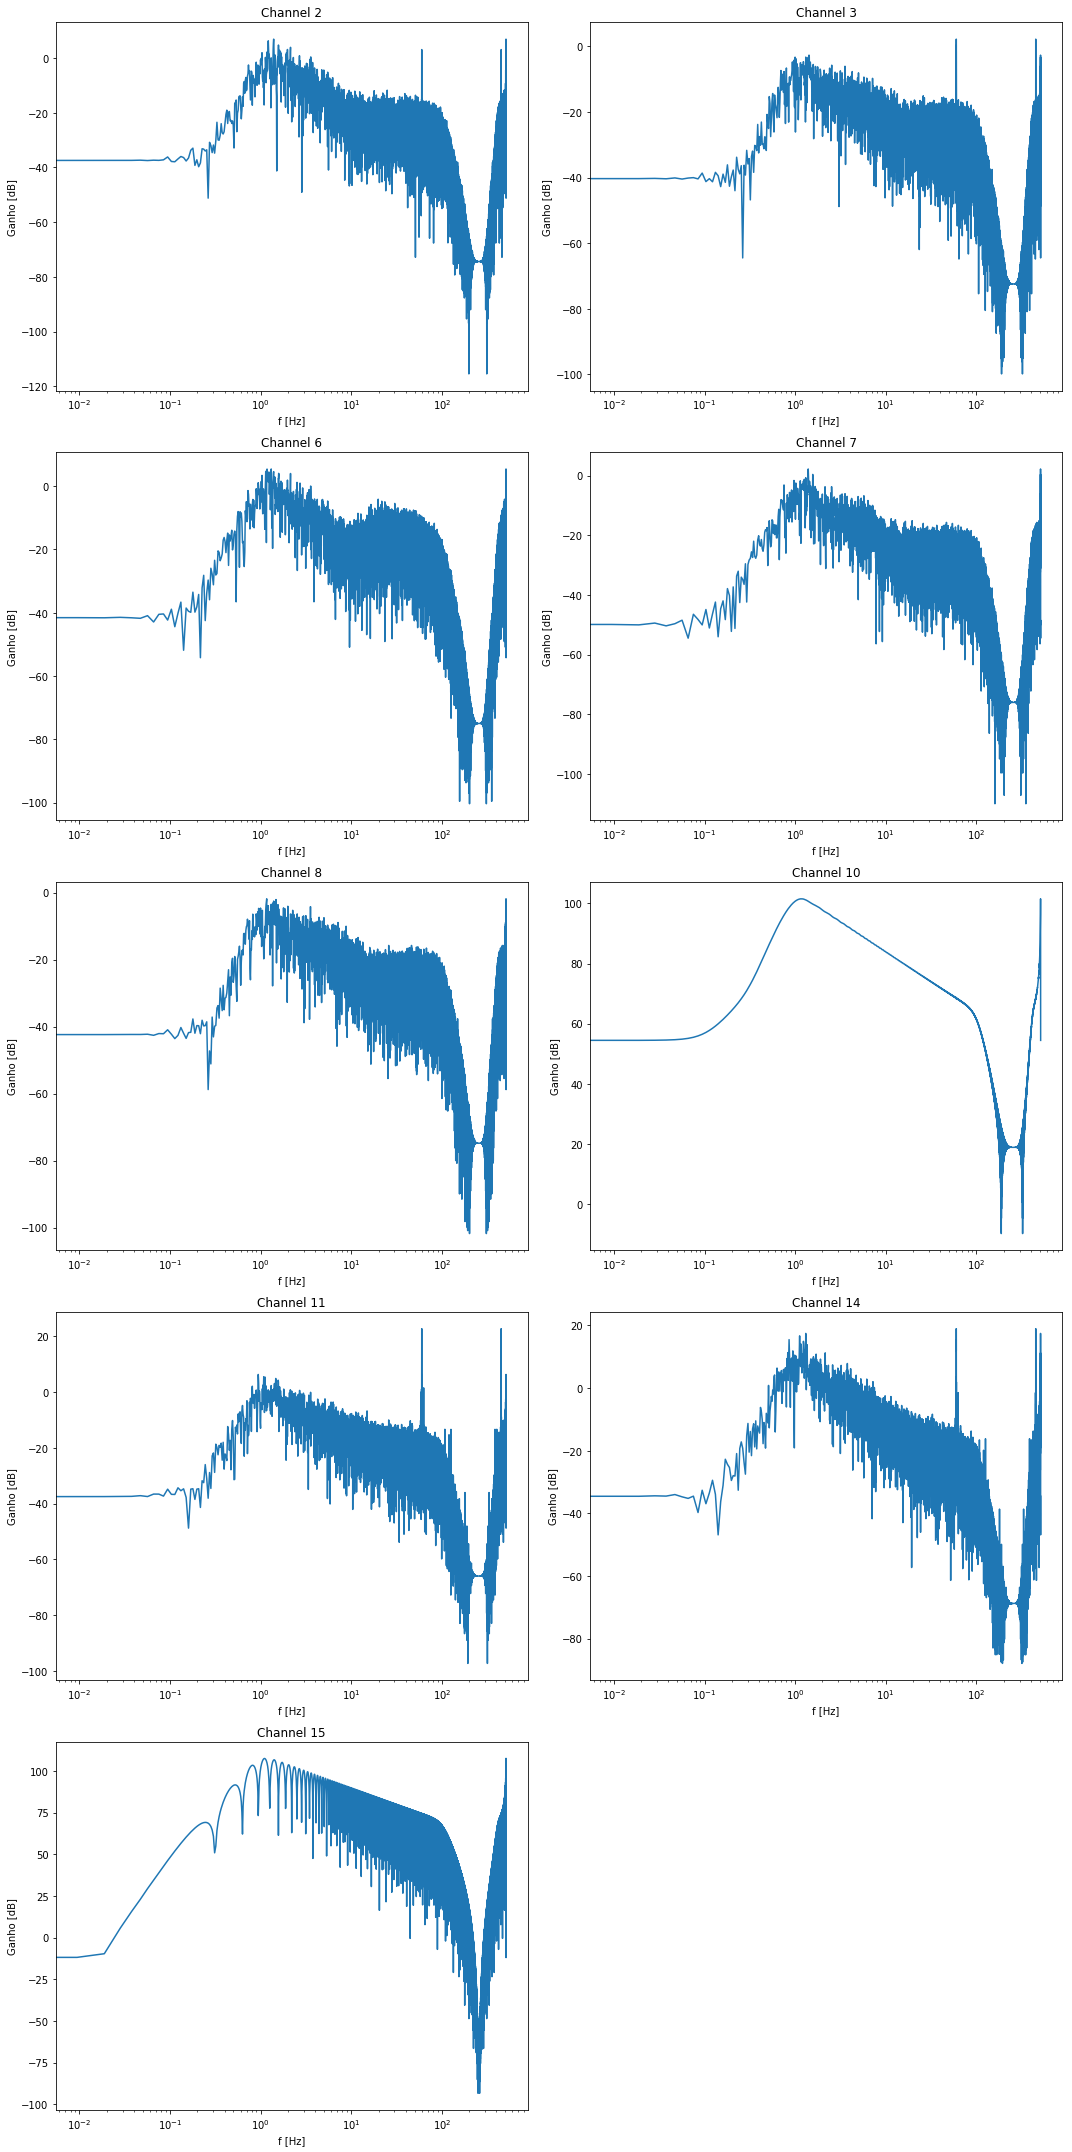

In [10]:
def bodePlot(frq_data):
    fig, ax = plt.subplots(5, 2, figsize=(15,30))
    line = 0
    column = 0
    for key in frq_data:
        ax[line][column].semilogx(frq_range, 20*(np.log(abs(frq_data[key]))/np.log(10)))
        ax[line][column].set_title(key)
        ax[line][column].set_xlabel("f [Hz]")
        ax[line][column].set_ylabel("Ganho [dB]")
        if(column == 1):
            line += 1
            column = 0
        else:
            column = 1

    fig.delaxes(ax[4][1])
    plt.tight_layout()
    
bodePlot(frq_data)

In [11]:
# Filtragem dos dados:
filtered_data = pd.DataFrame()
for key in data:
    filtered_data[key] = myfilter(sample_rate, data[key], blinking_signal_frq, filter_order)
    
filtered_time_data = time_data[0:(len(filtered_data[filtered_data.keys()[0]]))]

TypeError: unsupported operand type(s) for ^: 'bool' and 'str'